# **Data Download and Imports**

**Imports and helpful functions**

In [ ]:
import os
import sys
import subprocess
from google_drive_downloader import GoogleDriveDownloader as gdd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random
import cv2
import csv
import glob
import numpy as np
from PIL import Image
from numpy import asarray
from pydrive.auth import GoogleAuth
from google.colab import auth
IMG_SIZE=64

In [ ]:
#returns array of images loaded from a folder
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            images.append(img)
    return images

**Dataset Download**


```
ID: 1CRFmFSKnELO7mdTq9hNFcxzcAe1OcwHo
```



In [ ]:
FILE_ID = '1CRFmFSKnELO7mdTq9hNFcxzcAe1OcwHo'
PROCESSED_DATA_DIR = 'processed'
gdd.download_file_from_google_drive(
    file_id=FILE_ID,
    dest_path=os.path.join(PROCESSED_DATA_DIR, 'data.zip'),
    unzip=True
)

print("Removing downloaded zip file ...")
os.remove(os.path.join(PROCESSED_DATA_DIR, 'data.zip'))
print("Finished")

Unzipping...Done.
Removing downloaded zip file ...
Finished


**Dataset Loading**

In [ ]:
#slightly altered code to load the dataset
#source: GTSRB


# The German Traffic Sign Recognition Benchmark
#
# sample code for reading the traffic sign images and the
# corresponding labels
#

# function for reading the images
# arguments: path to the traffic sign data, for example './GTSRB/Training'
# returns: list of images, list of corresponding labels 
def readTrafficSigns(rootpath):
    '''Reads traffic sign data for German Traffic Sign Recognition Benchmark.

    Arguments: path to the traffic sign data, for example './GTSRB/Training'
    Returns:   list of images, list of corresponding labels'''
    images = [] # images
    labels = [] # corresponding labels
    width = []
    height = []
    x1 = []
    y1 = []
    x2 = []
    y2 = []
    # loop over all 42 classes
    for c in range(0,43):
        #print("Loading class",format(c,"02d"),"...")
        prefix = rootpath + '/' + format(c, '05d') + '/' # subdirectory for class
        gtFile = open(prefix + 'GT-'+ format(c, '05d') + '.csv') # annotations file
        gtReader = csv.reader(gtFile, delimiter=';') # csv parser for annotations file
        next(gtReader) # skip header
        # loop over all images in current annotations file
        for row in gtReader:
            images.append(plt.imread(prefix + row[0])) # the 1th column is the filename
            labels.append(row[7]) # the 8th column is the label
            width.append(int(row[1]))
            height.append(int(row[2]))
            x1.append(int(row[3]))
            y1.append(int(row[4]))
            x2.append(int(row[5]))
            y2.append(int(row[6]))
        gtFile.close()
    return images, labels, width, height, x1, y1, x2, y2

print("Loading data...")
images, labels, imgWidth, imgHeight, imgX1, imgY1, imgX2, imgY2  = readTrafficSigns(PROCESSED_DATA_DIR+'/GTSRB/Final_Training/Images')
print("Finished loading")
print("Images:",len(images), len(labels))


**Road Dataset Download**
```
ID: 15AbOfnhnmr935ozkPA7iTSio_usVbuMm
```




In [ ]:
FILE_ID = '15AbOfnhnmr935ozkPA7iTSio_usVbuMm'
PROCESSED_DATA_DIR = 'processed'
gdd.download_file_from_google_drive(
    file_id=FILE_ID,
    dest_path=os.path.join(PROCESSED_DATA_DIR, 'roads.zip'),
    unzip=True
)

print("Removing downloaded zip file ...")
os.remove(os.path.join(PROCESSED_DATA_DIR, 'roads.zip'))
print("Finished")

# **Image Processing**

Road Samples Extractor

In [ ]:
roads = load_images_from_folder('processed/Random images')

#generating dark images
for i in range(len(roads)):
  road=roads[i]
  img = Image.fromarray(road)
  darkRoad = img.point(lambda p: p * 0.35)
  darkRoadArray = asarray(darkRoad)
  roads.append(darkRoadArray)

numOfNegativeSamples = 0
discardedNegativeSamples = 0
for road in roads:
  h, w, c = road.shape
  for i in range(0, h, IMG_SIZE):  
      for j in range(0, w, IMG_SIZE):
          if i!=0 or j!=0:
            tile = road[i:i+IMG_SIZE, j:j+IMG_SIZE,:]
            th,tw,tc = tile.shape
            if th==IMG_SIZE and tw==IMG_SIZE:
              images.append(tile)
              labels.append(str(43))
              numOfNegativeSamples+=1
            else:
              discardedNegativeSamples+=1
              
print(str(numOfNegativeSamples)+" road tiles loaded.")
print(str(discardedNegativeSamples)+" road tiles discarded.")

 **Saving dataset to match YOLO's input format**

YOLO folder format:
```
./images/im0.jpg  # image
./labels/im0.txt  # label
```


Each row is `class x_center y_center width height` format.

Range:  `[0,1]`

In [ ]:
paths = ['./dataset/train/images','./dataset/train/labels','./dataset/val/images','./dataset/val/labels',]

datasetLength = len(images)

for path in paths:
  try:
    os.makedirs(path)
    print("Created "+path)
  except FileExistsError:
    print(path+" exists")

numOfImagesByClass = []
for i in range(44):
  numOfImagesByClass.append(0)

for i in range(datasetLength):
  img = images[i]
  if int(labels[i])!=43:
    width = (1.0*imgX2[i]-imgX1[i])/imgWidth[i]
    height = (1.0*imgY2[i]-imgX1[i])/imgHeight[i]
    imgData = labels[i]+" "+str((1.0*imgX1[i]+imgX2[i])/2/imgWidth[i])+" "+str((1.0*imgY1[i]+imgY2[i])/2/imgHeight[i])+" "+str(width)+" "+str(height)
  else:
    imgData=''
  
  if numOfImagesByClass[int(labels[i])]%5 == 0:
    parent = 'val/'
  else:
    parent = 'train/'
  numOfImagesByClass[int(labels[i])]+=1
  with open('dataset/'+parent+'labels/im{:05d}.txt'.format(i), 'w') as f:
    f.write(imgData)
    f.write('\n')

  im = Image.fromarray(img)
  im.save('dataset/'+parent+'images/im{:05d}.jpg'.format(i))



print("Finished writing all data")
print(numOfImagesByClass)

# **Examples**

In [ ]:
datasetLength = len(images)

croppedImages = []
trainImages = []
print("Processing...")
for i in range(datasetLength):
  img = images[i]
  if int(labels[i])!=43:
    croppedImg= img[imgY1[i]:imgY2[i], imgX1[i]:imgX2[i],:]
  else:
    croppedImg=img
  croppedImages.append(croppedImg)
  resizedImg = cv2.resize(croppedImg, (IMG_SIZE, IMG_SIZE))
  trainImages.append(resizedImg)
print("Processed all images.")


**Image Example**

In [ ]:
EXAMPLE_ID=25

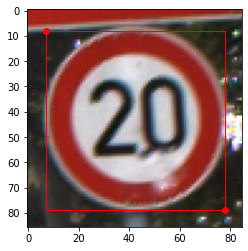

In [ ]:
plt.imshow(images[EXAMPLE_ID])
exampleX1 = imgX1[EXAMPLE_ID]
exampleY1 = imgY1[EXAMPLE_ID]
exampleX2 = imgX2[EXAMPLE_ID]
exampleY2 = imgY2[EXAMPLE_ID]
rect = patches.Rectangle((exampleX1, exampleY1), exampleX2-exampleX1, exampleY2-exampleY1, linewidth=1, edgecolor='r', facecolor='none')
plt.gca().add_patch(rect)
plt.plot(exampleX1,exampleY1,'ro')
plt.plot(exampleX2,exampleY2,'ro')
plt.show()


**Cropped Example**

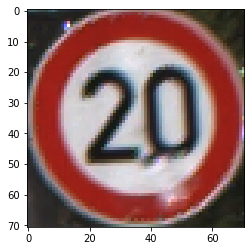

In [ ]:
plt.imshow(croppedImages[EXAMPLE_ID])
plt.show()

**Resized Example**

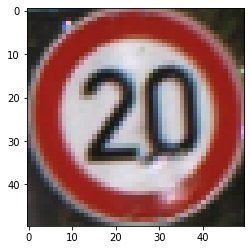

In [ ]:
plt.imshow(trainImages[EXAMPLE_ID])
plt.show()

**Before processing**

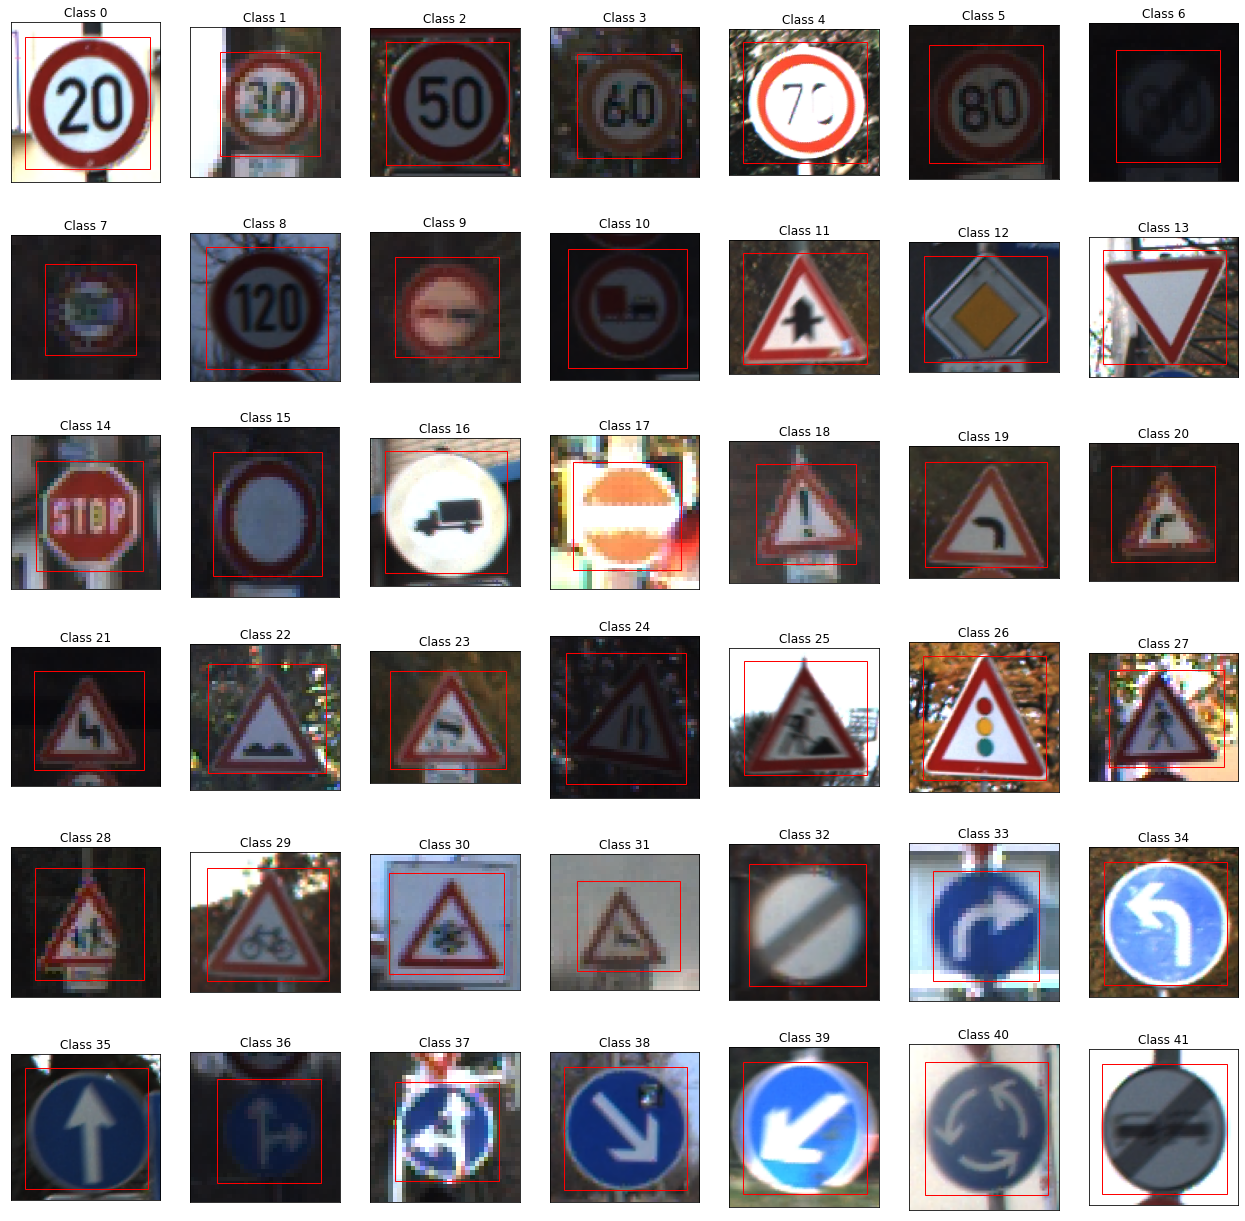

In [ ]:
EXAMPLE_ROWS = 6
EXAMPLE_COLUMNS = 7
fig, axs = plt.subplots(EXAMPLE_ROWS, EXAMPLE_COLUMNS)
fig.set_size_inches(22, 22)
ID = []
for j in range(EXAMPLE_ROWS):
  for i in range(EXAMPLE_COLUMNS): 
    RAND_ID = random.randint(0,len(labels)-1)
    while(int(labels[RAND_ID])!=i+7*j):
      RAND_ID = random.randint(0,len(labels))
    ID.append(RAND_ID)
    axs[j, i].imshow(images[RAND_ID])
    axs[j, i].set_title('Class '+str(i+7*j))
    X1 = imgX1[RAND_ID]
    Y1 = imgY1[RAND_ID]
    X2 = imgX2[RAND_ID]
    Y2 = imgY2[RAND_ID]
    axs[j, i].add_patch( patches.Rectangle((X1, Y1), X2-X1, Y2-Y1, linewidth=1, edgecolor='r', facecolor='none'))
    axs[j, i].set_xticks([])
    axs[j, i].set_yticks([])
plt.show()

**After processing**

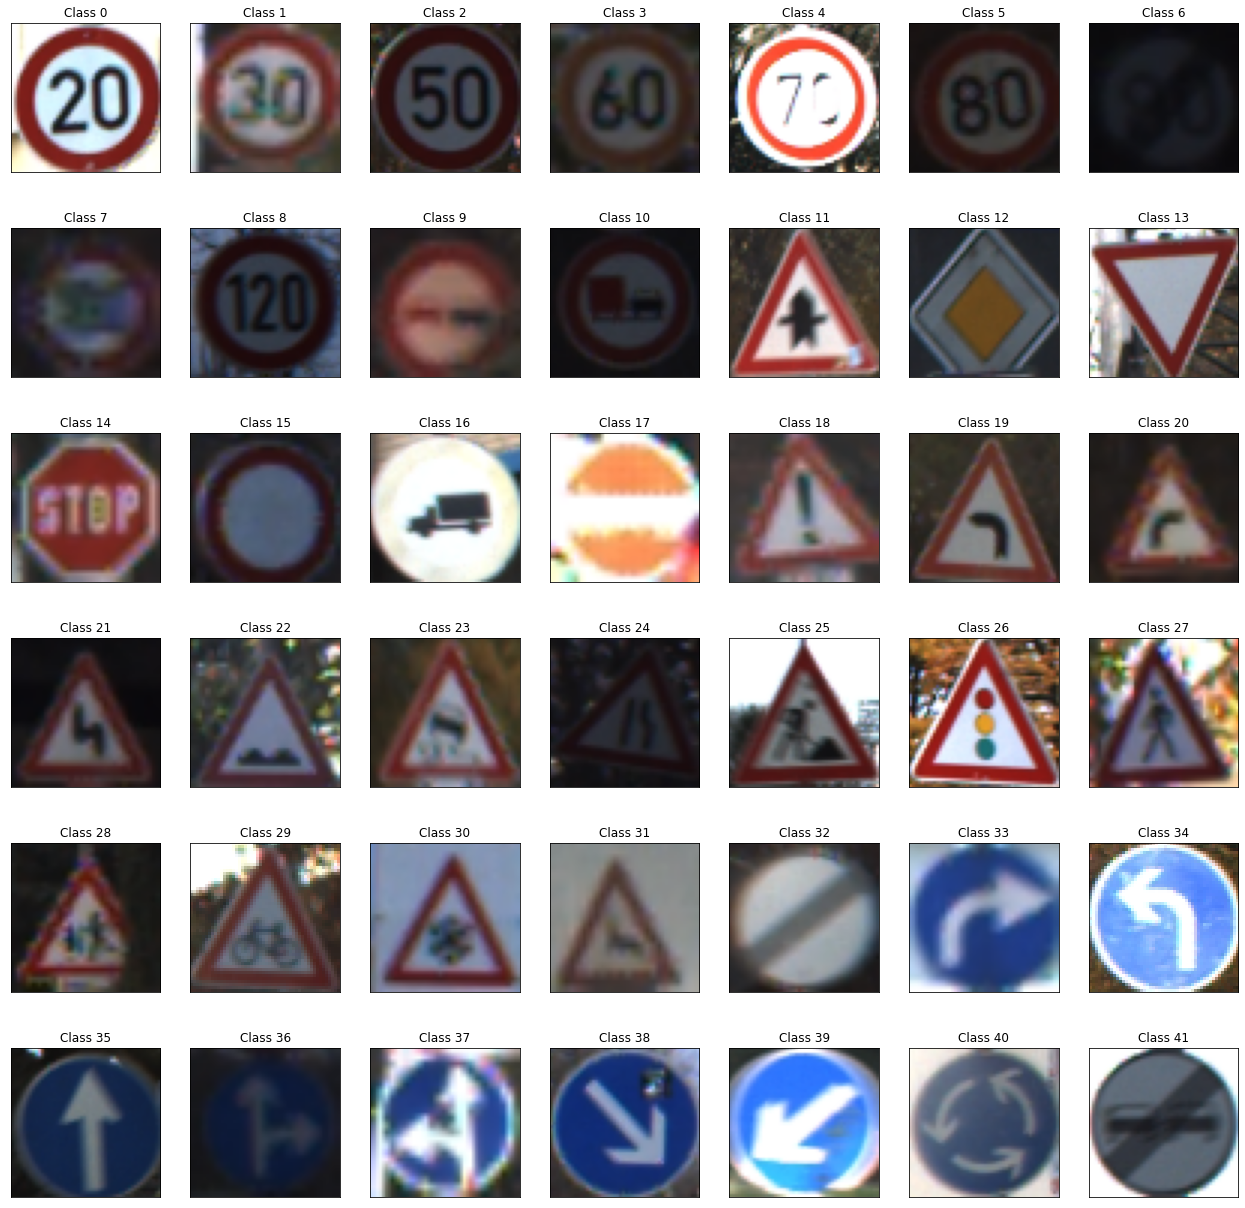

In [ ]:
EXAMPLE_ROWS = 6
EXAMPLE_COLUMNS = 7
fig, axs = plt.subplots(EXAMPLE_ROWS, EXAMPLE_COLUMNS)
fig.set_size_inches(22, 22)

for j in range(EXAMPLE_ROWS):
  for i in range(EXAMPLE_COLUMNS): 
    RAND_ID = ID[i+7*j]
    axs[j, i].imshow(trainImages[RAND_ID])
    axs[j, i].set_title('Class '+str(i+7*j))
    axs[j,i].set_xticks([])
    axs[j,i].set_yticks([])


#**Video**

Some helpful code for video manipulation

Video download

15 FPS driving video: `1ss01eDFFfgOnjLPzhZTZL6kBcYjxRmHz`

30 FPS driving video: `1a4TwifLonY56ERCR1afhnKq1Zyb8MFMi`



In [ ]:
FILE_ID = '1a4TwifLonY56ERCR1afhnKq1Zyb8MFMi'
PROCESSED_DATA_DIR = 'video'
gdd.download_file_from_google_drive(
    file_id=FILE_ID,
    dest_path=os.path.join(PROCESSED_DATA_DIR, 'driving.mp4')
)
print("Finished")

Video to .jpg frames


In [ ]:
vidcap = cv2.VideoCapture('video/driving.mp4')
fps = vidcap.get(cv2.CAP_PROP_FPS)
success,image = vidcap.read()
count = 0
frames = []
try:
    os.mkdir("./frames")
    print("Created /frames")
except FileExistsError:
  print("/frames exists")
while success and count<3000: #limit frames to 3000
  #frames.append(image)
  cv2.imwrite("./frames/frame%07d.jpg" % count, image)     # save frame as JPEG file      
  success,image = vidcap.read()
  count += 1
  if count%100==0:
    print(count)
print(fps,"FPS")
print("Read",count,"frames")
#frames.clear()

.jpg frames to video

In [ ]:
img_array = []
filename_array = []
for filename in glob.glob('./runs/detect/exp/*.jpg'):
  filename_array.append(str(filename)) 

filename_array.sort()
count =0
for filename in filename_array:
  img = cv2.imread(filename)
  height, width, layers = img.shape
  size = (width,height)
  img_array.append(img)
  count+=1
  if count%100==0:
    print(count)
 
out = cv2.VideoWriter('detectedVideo.avi',cv2.VideoWriter_fourcc(*'DIVX'), fps, size)
 
for i in range(len(img_array)):
  out.write(img_array[i])
out.release()

# **YOLOV5 Training and Testing**



Cloning YOLOv5 files from the official repository

In [ ]:
!git clone https://github.com/ultralytics/yolov5.git

Changing dir

In [ ]:
%cd yolov5/

/content/yolov5


Installing dependencies

In [ ]:
!pip install -r requirements.txt

**STEPS BEFORE TRAINING/TESTING:**
1. Go to yolov5/data/
2. Open coco128.yaml
3. Edit the following inside it:
    

      1.   Training and Test file path
      2.   Number of classes and Class names.

The modified coco128.yaml file and the trained weights can be found here:
https://github.com/iangolob/Traffic-Sign-Recognition


 **Train from pretrained weights**

In [ ]:
!python train.py --img 64 --batch 1024 --epochs 3 --data coco128.yaml --weights yolov5s.pt --nosave --cache 

**Continue training**

In [ ]:
!python train.py --weights runs/train/exp/weights/last.pt --epochs 100 --img 64 --batch 256

**Testing**

In [ ]:
!python test.py --weights bestWeights.pt --data coco128.yaml --img 64 

**Detection on new images/videos**

To detect traffic signs on your images or videos create a folder
`./yolov5/images/`
and put your images or videos in that folder.

The output can be found in `./yolov5/runs/detection`





In [ ]:
!python detect.py --source images/ --weights bestWeights.pt --img 1280  --save-txt --save-conf --conf-thres 0.3 --line-thickness 2


**Visualizing training data**

In [ ]:
%load_ext tensorboard
%tensorboard --logdir runs/train/